In [1]:
import numpy as np
import quaternion as qt
from eulerangles import EulerAngleConvention, euler2euler, matrix2euler
import matplotlib.pyplot as plt
import scipy.linalg
import constants
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def RK4(f, x0x1, y0, step, step_process = lambda y: y):
    # f MUST takes x and y as arguments: f(x, y)
    # It solves equation y' = f(x, y), y(x0) = y0 (everything is a vector)
    # from x0x1[0] to x0x1[1] on the grid with step step
    # step_process - FUNCTION that is called after every step to somehow process results (normalization and so on)
    # step_process - must take y argument (for single time step) as input and return the same shape numpy.ndarray
    # by default it doesn't do anything
    # returns array of (x, y) pairs
    x0 = x0x1[0]
    x1 = x0x1[1]
    current_x = np.array(x0, dtype = np.float64)
    current_y = np.array(y0, dtype = np.float64)
    result = [[x0, *y0]]
    h = step
    h2 = h/2
    h6 = h/6
    stop = x1 - h
    while current_x < stop:
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        result.append(np.array([current_x.copy(), *current_y.copy()]))

    if current_x < x1 - constants.max_to_zero:
        h = x1 - current_x
        h2 = h/2
        h6 = h/6
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        result.append(np.array([current_x.copy(), *current_y.copy()]))       
    
    return np.array(result)

def Euler(t, w, M = (0, 0, 0)):
    # return w' accroding to Euler's dinamic equation
    global J, Jinv
    return Jinv @ (M - np.cross(w, J @ w))

J = np.zeros((3, 3))
J[0,0] = 1
J[1, 1] = 1
J[2, 2] = 2
Jinv = scipy.linalg.inv(J)

## 1. Матрица направляющих косинусов
Матрица **A**<sup>T</sup> состоит из столбцов координат связанного базиса **e** в ИСО **i**, т.е. по факту это матрица перехода (как в линале) от базиса **i** к базису **e**. Т.к. базисы ортонормированы, то матрица будет ортогональной и матрица перехода в смысле координат будет равна просто **A**
$$A_{k,m} = (\textbf{i}_m,\textbf{e}_k)\\\textbf{AA}^{T} = \textbf{E}\\\dot{\textbf{A}}=-[\textbf{w}^{e}]_x\textbf{A}\\\textbf{J}^e\dot{\textbf{w}^e} + [\textbf{w}^e,\textbf{J}^e{\textbf{w}^e}]=\textbf{M}^e_c$$
Где **a**<sub>x</sub> суть матрица 
$$0\;-a_3\;a_2\\a_3\;\;0\;-a_1\\-a_2\;\;a_1\;\;\;0$$

In [3]:
def Adot(t, A, w):
    wx = np.zeros((3, 3))
    wx[0, 1] = -w[2]
    wx[0, 2] = w[1]
    wx[1, 0] = w[2]
    wx[1, 2] = -w[0]
    wx[2, 0] = -w[1]
    wx[2, 1] = w[0]
    return -wx @ A

def f1(t, x):
    # in this case x has 3 + 3x3 = 12 size
    # x[:3] - angular velocity; x[3:] - A.ravel()
    global J
    w = x[:3]
    A = np.reshape(x[3:], (3, 3)) # note: A = np.reshape(A.ravel(), A.shape)
    res = np.empty(12)
    res[:3] = Euler(t, w)
    res[3:] = Adot(t, A, w).ravel()
    return res

def orthogonalization(x):
    # orthogonalizes the martrix A 3x3 assuming string is a basis-vector
    # from RK4 it comes in like a vectir with (12,) shape where first three elements are from angular velocity
    w = x[:3]
    A = np.reshape(x[3:], (3, 3)) # note: A = np.reshape(A.ravel(), A.shape)
    res = np.empty(12)
    res[:3] = w
    
    e1 = A[0, :]
    e1 /= np.linalg.norm(e1)
    e2 = A[1, :]
    e2 -= np.dot(e2, e1)*e1
    e2 /= np.linalg.norm(e2)
    e3 = A[2, :]
    e3 -= np.dot(e3, e2)*e2 + np.dot(e3, e1)*e1    
    e3 /= np.linalg.norm(e3)
    
    res[3:] = np.array([e1, e2, e3]).ravel()
    
    return res

In [4]:
# Интегрирование тут
t0 = 0.
t1 = 10.
step = 0.01
A0 = np.eye(3)
w0 = np.array([1, 1, 1])
x0 = np.hstack((w0, A0.ravel()))

result = RK4(f1, (t0, t1), x0, step, step_process = orthogonalization)

In [5]:
t_points = result[:, 0]
we = result[:, 1:4]
A = result[:, 4:].reshape((t_points.shape[0], 3, 3))
AT = A.transpose((0, 2, 1)) # Матрица перехода как в линале
wi = np.array([j.T @ i for i, j in zip(we, A)])

In [6]:
# Смотрю, как сильно "съехала" матрица A
np.max(np.abs(AT[-1]@A[-1] - np.eye(3)))

1.1102230246251565e-16

### Проверка
Должны сохраняться:
1. Кин. момент
2. Энергия вращательного движения
3. В случае эйлера A = B != C сохраняется так же проекция угловой скорости на e3 (ось динамической симметрии) и ось e3 будет соврешать прецессию по окружности

In [7]:
e3 = AT[:, :, 2]
e2 = AT[:, :, 1]
e1 = AT[:, :, 0]

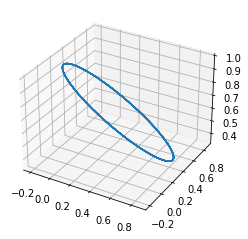

In [8]:
# Посмотрим как движется e3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*e3.T)
pass

In [9]:
# Кин. момент
Ke = np.array([J @ i for i in we]) # Связанный с телом
Ki = np.array([j @ J @ i for (i, j) in zip(we, AT)]) # В ИСО

Максимальное отклонение модуля кин. момента в связанном базисе: 5.6705751205754495e-12


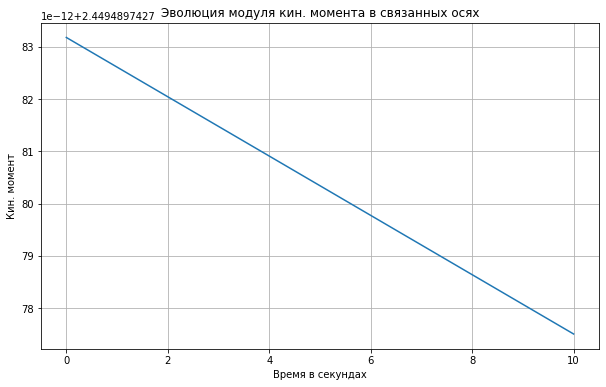

In [10]:
Ken = np.linalg.norm(Ke, axis = 1)

fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(10)

axes.plot(t_points, Ken)
axes.set_title("Эволюция модуля кин. момента в связанных осях")
axes.set_xlabel("Время в секундах")
axes.set_ylabel("Кин. момент")
axes.grid(True)

print("Максимальное отклонение модуля кин. момента в связанном базисе:", np.max(np.abs(Ken - Ken[0])))

Максимальное отклонение кин. момента в ИСО: 1.4523853231196426e-09


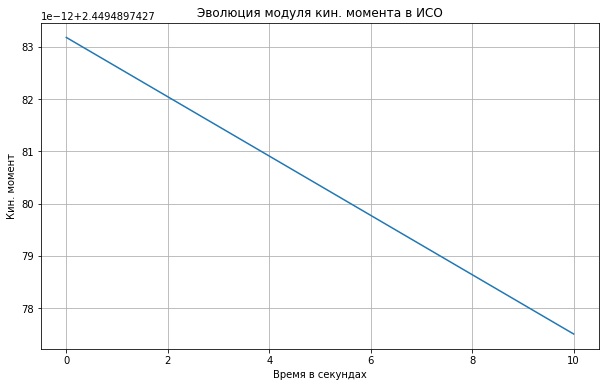

In [11]:
Kin = np.linalg.norm(Ki, axis = 1)

fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(10)

axes.plot(t_points, Kin)
axes.set_title("Эволюция модуля кин. момента в ИСО")
axes.set_xlabel("Время в секундах")
axes.set_ylabel("Кин. момент")
axes.grid(True)

print("Максимальное отклонение кин. момента в ИСО:", np.max(np.abs(Ki - Ki[0])))

Максимальное отклонение энергии в e: 2.7780888700590367e-11


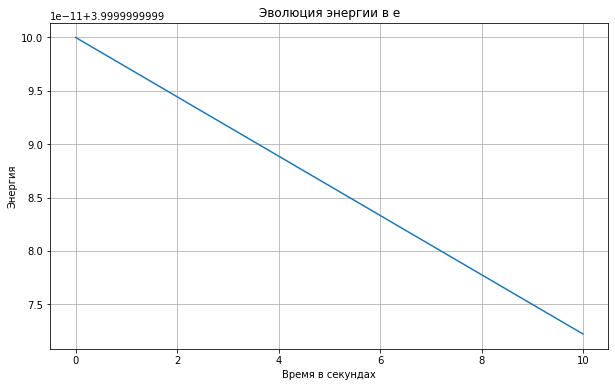

In [12]:
# Энергия
Te = np.array([np.dot(i, J @ i) for i in we])

fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(10)

axes.plot(t_points, Te)
axes.set_title("Эволюция энергии в e")
axes.set_xlabel("Время в секундах")
axes.set_ylabel("Энергия")
axes.grid(True)

print("Максимальное отклонение энергии в e:", np.max(np.abs(Te - Te[0])))

Максимальное отклонение энергии в e: 2.7782220968219917e-11


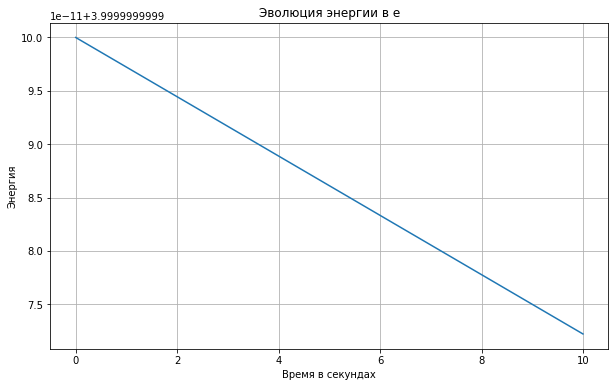

In [13]:
Ti = np.array([np.dot(i, j.T @ J @ j @ i) for i, j in zip(wi, A)])
# Ji = A.T Je A

fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(10)

axes.plot(t_points, Ti)
axes.set_title("Эволюция энергии в e")
axes.set_xlabel("Время в секундах")
axes.set_ylabel("Энергия")
axes.grid(True)

print("Максимальное отклонение энергии в e:", np.max(np.abs(Ti - Ti[0])))

Максимальное отклонение e3 проекции угловой скорости в e: 0.0


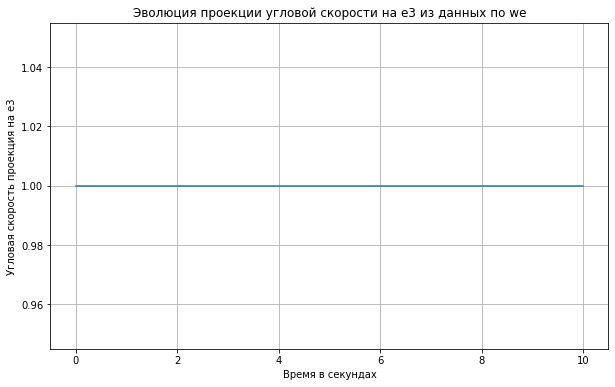

In [14]:
wee3 = we[:, 2]

fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(10)

axes.plot(t_points, wee3)
axes.set_title("Эволюция проекции угловой скорости на e3 из данных по we")
axes.set_xlabel("Время в секундах")
axes.set_ylabel("Угловая скорость проекция на e3")
axes.grid(True)

print("Максимальное отклонение e3 проекции угловой скорости в e:", np.max(np.abs(wee3 - wee3[0])))

Максимальное отклонение e3 проекции угловой скорости в ИСО: 4.440892098500626e-16


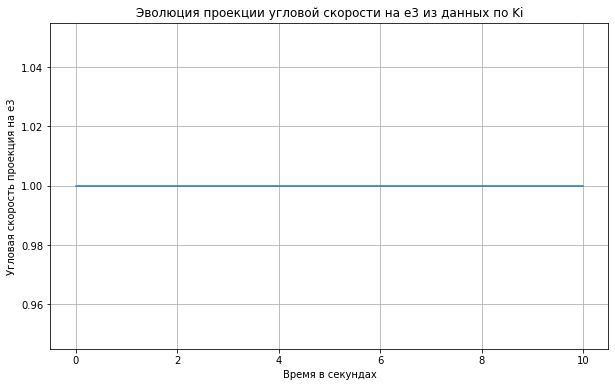

In [15]:
wie3 = np.array([np.dot(i, j) for i, j in zip(wi, e3)])

fig, axes = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(10)

axes.plot(t_points, wie3)
axes.set_title("Эволюция проекции угловой скорости на e3 из данных по Ki")
axes.set_xlabel("Время в секундах")
axes.set_ylabel("Угловая скорость проекция на e3")
axes.grid(True)

print("Максимальное отклонение e3 проекции угловой скорости в ИСО:", np.max(np.abs(wie3 - wie3[0])))

## 2. Самолётные углы (2-3-1)
Самолётные углы устроены так:  
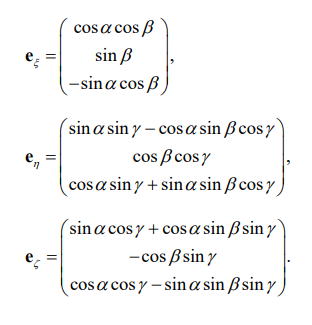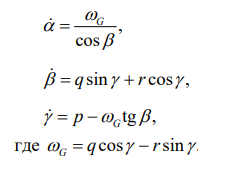  
Добавля к ним  
$$\textbf{J}^e\dot{\textbf{w}^e} + [\textbf{w}^e,\textbf{J}^e{\textbf{w}^e}]=\textbf{M}^e_c$$
Получаем замкнутую систему. Далее в коде альфа - fi1, бетта - fi2, гамма - fi3

In [16]:
def DotAngles(t, angles, we):
    # angles: fi1, fi2, fi3
    # we - angular velocity bounded to the body
    p = we[0]
    q = we[1]
    r = we[2]
    fi1 = angles[0]
    fi2 = angles[1]
    fi3 = angles[2]
    
    wg = q*np.cos(fi3) - r*np.sin(fi3)
    
    fi1d = wg/np.cos(fi2)
    fi2d = q*np.sin(fi3) + r*np.cos(fi3)
    fi3d = p - wg*np.tan(fi2)
    return np.array([fi1d, fi2d, fi3d])

def f2(t, x):
    # x: p, q, r, fi1, fi2, fi3
    global J
    we = x[:3]
    angles = x[3:]
    result = np.empty(6)
    result[:3] = Euler(t, we)
    result[3:] = DotAngles(t, angles, we)
    return result

In [47]:
# Интегрирование тут
t0 = 0.
t1 = 10.
step = 0.001
angles0 = np.array([0, np.pi/2 - 1e-3, 0])

we0 = np.array([1, 1, 1])
x0 = np.hstack((we0, angles0))

result = RK4(f2, (t0, t1), x0, step)

t_points = result[:, 0]
we = result[:, 1:4]
angles = result[:, 4:]
fi1 = angles[:, 0]
fi2 = angles[:, 1]
fi3 = angles[:, 2]

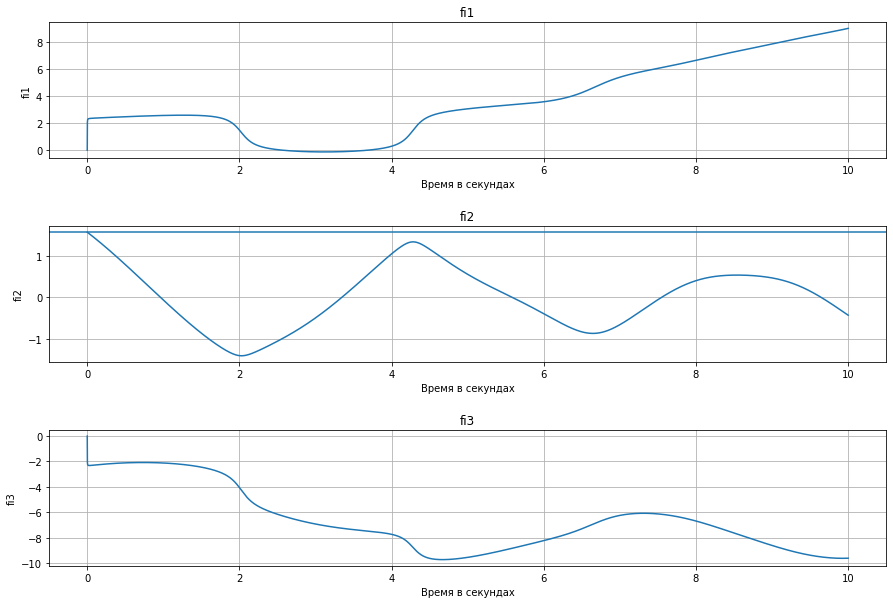

In [48]:
# Нарисую углы
fig, axes = plt.subplots(3)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.subplots_adjust(hspace = 0.5)

axes[0].plot(t_points, fi1)
axes[0].set_title("fi1")
axes[0].set_xlabel("Время в секундах")
axes[0].set_ylabel("fi1")
axes[0].grid(True)

axes[1].plot(t_points, fi2)
axes[1].set_title("fi2")
axes[1].set_xlabel("Время в секундах")
axes[1].set_ylabel("fi2")
axes[1].grid(True)
axes[1].axhline(np.pi/2)

axes[2].plot(t_points, fi3)
axes[2].set_title("fi3")
axes[2].set_xlabel("Время в секундах")
axes[2].set_ylabel("fi3")
axes[2].grid(True)

In [49]:
# Посчитаю конечну матрицу перехода как в линале
S1 = np.zeros((t_points.shape[0], 3, 3))
S1[:, 0, 0] = np.cos(fi1)
S1[:, 0, 2] = np.sin(fi1)
S1[:, 1, 1] = np.ones(t_points.shape[0])
S1[:, 2, 0] = -np.sin(fi1)
S1[:, 2, 2] = np.cos(fi1)
S2 = np.zeros((t_points.shape[0], 3, 3))
S2[:, 0, 0] = np.cos(fi2)
S2[:, 0, 1] = -np.sin(fi2)
S2[:, 1, 0] = np.sin(fi2)
S2[:, 1, 1] = np.cos(fi2)
S2[:, 2, 2] = np.ones(t_points.shape[0])
S3 = np.zeros((t_points.shape[0], 3, 3))
S3[:, 0, 0] = np.ones(t_points.shape[0])
S3[:, 1, 1] = np.cos(fi3)
S3[:, 1, 2] = -np.sin(fi3)
S3[:, 2, 1] = np.sin(fi3)
S3[:, 2, 2] = np.cos(fi3)
S = S1 @ S2 @ S3

Максимальное отклонение модуля кин. момента в связанном базисе: 3.1086244689504383e-15
Максимальное отклонение кин. момента в исо: 0.00010800866555582544


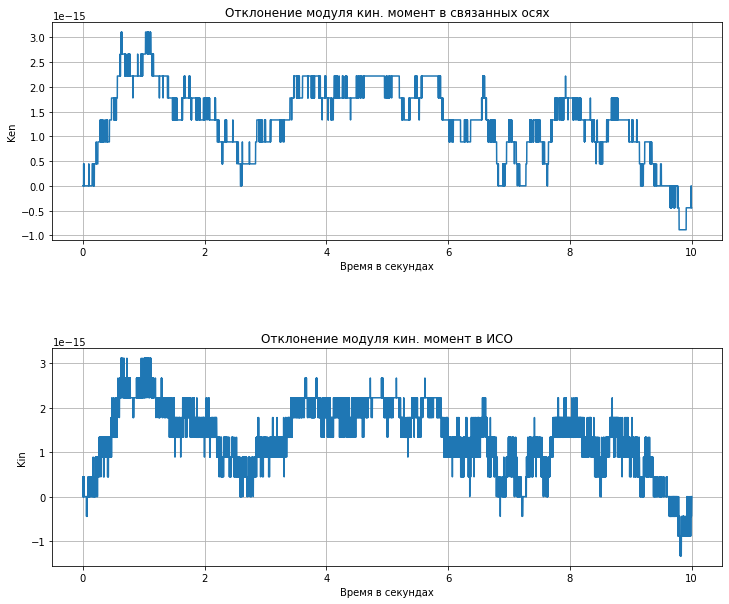

In [50]:
# Кин. момент
Ke = np.array([J @ i for i in we])
Ki = np.array([j @ i for i, j in zip(Ke, S)])
Ken = np.linalg.norm(Ke, axis = 1)
Kin = np.linalg.norm(Ki, axis = 1)

fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.subplots_adjust(hspace = 0.5)

axes[0].plot(t_points, Ken - Ken[0])
axes[0].set_title("Отклонение модуля кин. момент в связанных осях")
axes[0].set_xlabel("Время в секундах")
axes[0].set_ylabel("Ken")
axes[0].grid(True)

axes[1].plot(t_points, Kin - Kin[0])
axes[1].set_title("Отклонение модуля кин. момент в ИСО")
axes[1].set_xlabel("Время в секундах")
axes[1].set_ylabel("Kin")
axes[1].grid(True)

print("Максимальное отклонение модуля кин. момента в связанном базисе:", np.max(np.abs(Ken - Ken[0])))
print("Максимальное отклонение кин. момента в исо:", np.max(np.abs(Ki - Ki[0])))

Максимальное отклонение кин. энергии в связанном базисе: 1.4210854715202004e-14
Максимальное отклонение кин. энергии в исо: 1.5987211554602254e-14


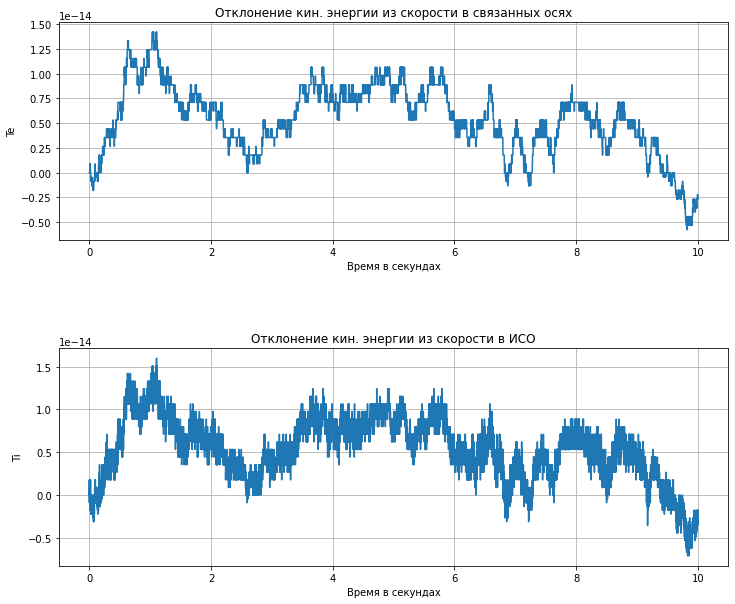

In [51]:
# Vis viva
Te = np.array([np.dot(i, J @ i) for i in we])
Ti = np.array([np.dot(j @ i, j @ J @ j.T @ j @ i) for i, j in zip(we, S)])

fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.subplots_adjust(hspace = 0.5)

axes[0].plot(t_points, Te - Te[0])
axes[0].set_title("Отклонение кин. энергии из скорости в связанных осях")
axes[0].set_xlabel("Время в секундах")
axes[0].set_ylabel("Te")
axes[0].grid(True)

axes[1].plot(t_points, Ti - Ti[0])
axes[1].set_title("Отклонение кин. энергии из скорости в ИСО")
axes[1].set_xlabel("Время в секундах")
axes[1].set_ylabel("Ti")
axes[1].grid(True)

print("Максимальное отклонение кин. энергии в связанном базисе:", np.max(np.abs(Te - Te[0])))
print("Максимальное отклонение кин. энергии в исо:", np.max(np.abs(Ti - Ti[0])))

In [52]:
# Перейду к базису, где кин. момент по OZ (с помощью кватерниона)
a0 = np.cos(np.arccos(Ki[0,2]/Kin[0])/ 2)
ezn = np.cross(np.array([0, 0, 1]), Ki[0])
ezn *= np.sqrt(1 - a0**2)/np.linalg.norm(ezn)
B = np.quaternion(a0, *ezn)
en1 = qt.as_float_array(B * np.quaternion(1, 0, 0) * B.inverse())[1:]
en2 = qt.as_float_array(B * np.quaternion(0, 1, 0) * B.inverse())[1:]
en3 = qt.as_float_array(B * np.quaternion(0, 0, 1) * B.inverse())[1:]
SS = np.array([en1, en2, en3])
SSS = SS @ S
angles2 = matrix2euler(SSS, target_axes = "ZXZ", target_positive_ccw=True, target_intrinsic=True)

Максимальное изменение theta: 0.0041394341550287095


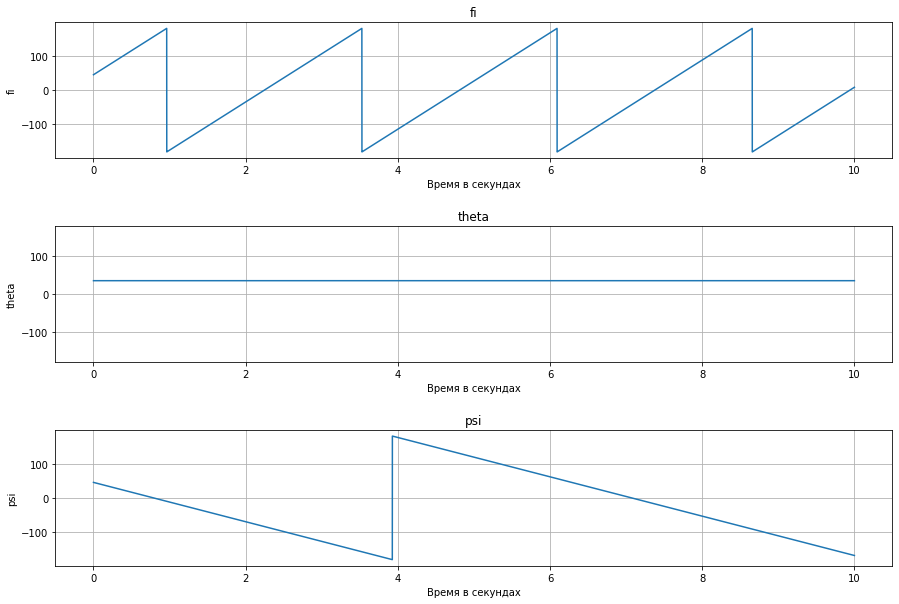

In [53]:
# Нарисую углы в новом базисе
fig, axes = plt.subplots(3)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.subplots_adjust(hspace = 0.5)

axes[0].plot(t_points, angles2[:, 0])
axes[0].set_title("fi")
axes[0].set_xlabel("Время в секундах")
axes[0].set_ylabel("fi")
axes[0].grid(True)

axes[1].plot(t_points, angles2[:, 1])
axes[1].set_ylim((-180, 180))
axes[1].set_title("theta")
axes[1].set_xlabel("Время в секундах")
axes[1].set_ylabel("theta")
axes[1].grid(True)

axes[2].plot(t_points, angles2[:, 2])
axes[2].set_title("psi")
axes[2].set_xlabel("Время в секундах")
axes[2].set_ylabel("psi")
axes[2].grid(True)

print("Максимальное изменение theta:", np.max(np.abs(angles2[:, 1] - angles2[0, 1])))

## 3. Кватернионы
Правило умножения кватернионов (напоминалка):  
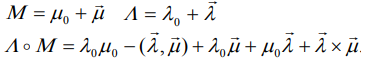
Сопряжённый кватернион:  
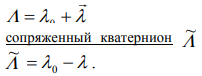
Обратный кватернион:
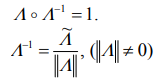
Задание поворота ЕДИНИЧНЫМ кватернионом (он задан в базисе i):
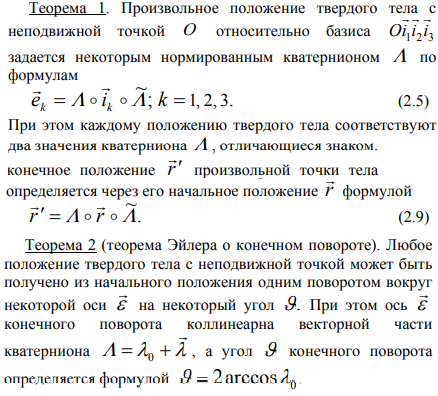
Сложение поворотов если A1...An заданы в базисе i:

Сложение поворотов кватернионов, заданых в собственном базисе (на момент поворота; параметры Родрига-Гамильтона):  
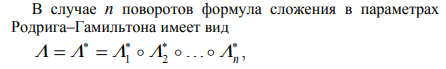
Эволюция кватерниона во времени, где кватернионы заданы в базисе i, w<sup>E</sup> это вектор в базисе i с координатами угловой скорости из базиса e (т.е. угловую скорость берём we и пихаем её в уравнение):
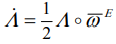

In [24]:
def QuatDot(Ai, we):
    return np.quaternion(Ai[0], *Ai[1:]) * np.quaternion(*we) * 0.5


def f3(t, x):
    # x[:3] - we, x[3:] - Ai
    global J
    we = x[:3]
    Ai = x[3:]
    res = np.empty(7)
    res[:3] = Euler(t, we)
    res[3:] = qt.as_float_array(QuatDot(Ai, we))
    return res

def normalization(x):
    we = x[:3]
    Ai = x[3:]
    Ai /= np.linalg.norm(Ai) # normalization
    res = np.empty(7)
    res[:3] = we
    res[3:] = Ai
    return res

In [25]:
# Интегрирование тут
t0 = 0.
t1 = 10.
step = 0.001
we0 = np.array([1, 1, 1])
A0 = np.quaternion(1, 0, 0, 0)
x0 = np.hstack((we0, qt.as_float_array(A0)))

result = RK4(f3, (t0, t1), x0, step, normalization)

In [26]:
time_points = result[:, 0]
we = np.array([np.quaternion(*i) for i in result[:, 1:4]])
A = qt.as_quat_array(result[:, 4:])
wi = np.array([(j * i * j.inverse()) for i, j in zip(we, A)])
rotations = []
for i in A:
    i = qt.as_float_array(i)
    ang = 2 * np.arccos(i[0])
    n = np.linalg.norm(i[1:])
    e = i[1:]/np.linalg.norm(i[1:]) if n!=0 else np.array([0, 0, 0])
    rotations.append(np.array([ang, *e]))
rotations = np.array(rotations)

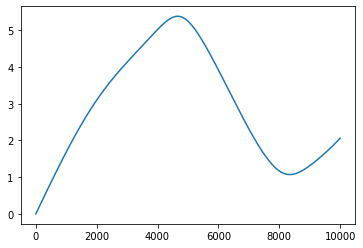

In [27]:
# Эволюция угла поворота
plt.plot(rotations[:, 0])

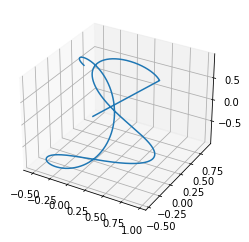

In [28]:
# Траектория, вектора оси поворота
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(rotations[:, 1], rotations[:, 2], rotations[:, 3])
pass

Максимальное изменение кин. момента в ИСО: 9.592326932761353e-14


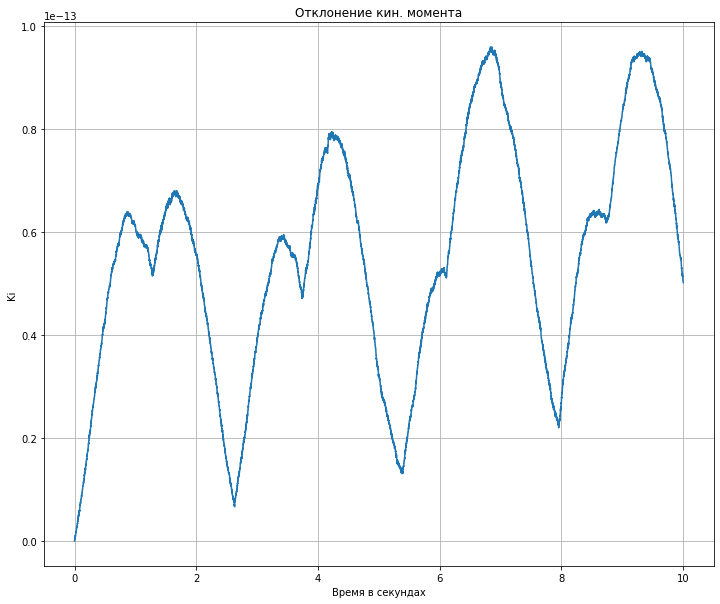

In [29]:
# Сохранение кин. момента
Ke = np.array([J @ qt.as_float_array(i)[1:] for i in we])
Ki = np.array([qt.as_float_array(j * np.quaternion(*i) * j.inverse())[1:] for i, j in zip(Ke, A)])


fig, axes = plt.subplots(1)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.subplots_adjust(hspace = 0.5)

axes.plot(time_points, [np.max(np.abs(i - Ki[0])) for i in Ki])
axes.set_title("Отклонение кин. момента")
axes.set_xlabel("Время в секундах")
axes.set_ylabel("Ki")
axes.grid(True)

print("Максимальное изменение кин. момента в ИСО:", np.max(np.abs(Ki - Ki[0])))

In [30]:
# Посмотрим, сохраняется ли угол между кин. моментом и осью динамической симметрии
qe3 = np.quaternion(0, 0, 1) # В начале совпадает с осью динамической симметрии
qe33 = np.array([qt.as_float_array(i * qe3 * i.inverse())[1:] for i in A])
theta = np.array([np.arccos(np.dot(Ki[0], i)/np.linalg.norm(Ki[0])) for i in qe33]) / np.pi * 180

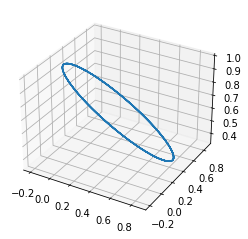

In [31]:
# Траектория оси динамической симметрии
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(qe33[:, 0], qe33[:, 1], qe33[:, 2])
pass

Максимальное изменение theta: 2.8634872251132037e-12


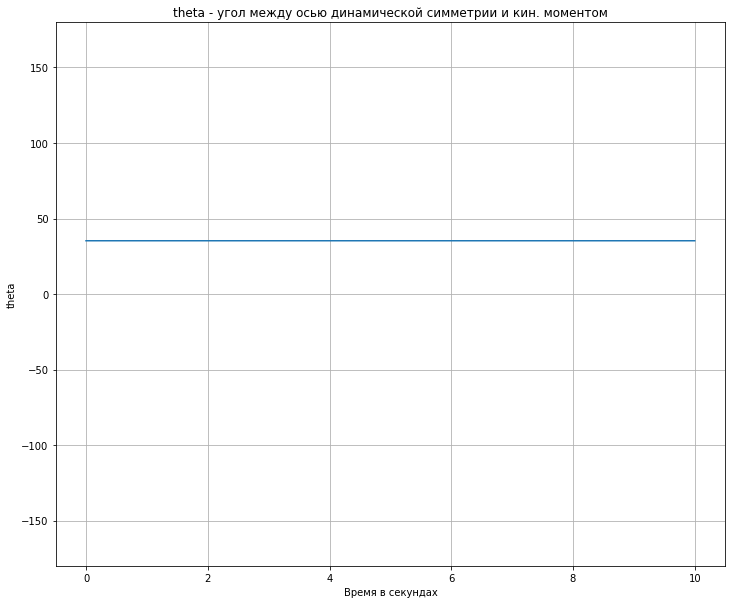

In [32]:
# Эволюция угла
fig, axes = plt.subplots(1)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.subplots_adjust(hspace = 0.5)

axes.plot(time_points, theta)
axes.set_ylim((-180, 180))
axes.set_title("theta - угол между осью динамической симметрии и кин. моментом")
axes.set_xlabel("Время в секундах")
axes.set_ylabel("theta")
axes.grid(True)

print("Максимальное изменение theta:", np.max(np.abs(theta - theta[0])))